## Rede Neural para Classificação de espectros 

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# imports do astropy
from astropy.io import fits

# imports do sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
# imports do tensorflow e keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Input, Dense, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import traceback
# para liberar memoria
import gc


In [2]:
# --- 1. Parâmetros & Configuração ---
CONFIG = {
    "fits_directory": Path('D:\sdss_spectra'),
    "target_length": 4000,
    "test_set_size": 0.10,
    "n_splits": 3,
    "shuffle_kfold": True,
    "random_state_kfold": 37,
    "random_state_test_split": 132,
    "epochs": 150,
    "final_model_epochs": 150,
    "batch_size": 128,
    "early_stopping_patience": 10,
    "redshift_filter_threshold": 1e-9,
    "pool_size": 4,
    "optimizer": "adam",
    "initial_learning_rate": 0.001,
    "decay_steps": 5000,
    "alpha": 0,
    "N_COMPONENTS": 5
}


In [3]:
from tqdm import tqdm 
from tqdm.keras import TqdmCallback 

In [4]:
#open specObj-dr17.fits
specObj = fits.open('specObj-dr17.fits')
#specObj.info() # to see the structure of the file
#specObj[1].header # to see the header of the first extension




In [5]:
def data_cleaning(specobj_fits_file, fits_files: list[Path]) -> list[Path]:
    """
    Filtra arquivos FITS de acordo com critérios de qualidade no catálogo specObj.
    Retorna apenas aqueles com PLATEQUALITY='good', ZWARNING=0 e SPECPRIMARY=1.
    Mostra uma barra de progresso do processamento.
    """
    # 1) Carrega catálogo specObj
    with fits.open(specobj_fits_file) as hdul:
        data = hdul[1].data
        
        # converte cada coluna em série pandas para permitir .str
        platequality = pd.Series(
            data['PLATEQUALITY']
            .byteswap().newbyteorder()
            .astype(str)
        ).str.strip().str.lower()
        
        df = pd.DataFrame({
            'PLATE':         data['PLATE'].byteswap().newbyteorder(),
            'MJD':           data['MJD'].byteswap().newbyteorder(),
            'FIBERID':       data['FIBERID'].byteswap().newbyteorder(),
            'PLATEQUALITY':  platequality,
            'ZWARNING':      data['ZWARNING'].byteswap().newbyteorder(),
            'SPECPRIMARY':   data['SPECPRIMARY'].byteswap().newbyteorder(),
        })

    # 2) Aplica filtros
    mask = (
        (df['PLATEQUALITY'] == 'good') &
        (df['ZWARNING']    == 0)    &
        (df['SPECPRIMARY'] == 1)
    )
    df_filtered = df.loc[mask, ['PLATE', 'MJD', 'FIBERID']]

    valid_keys = set(zip(
        df_filtered['PLATE'],
        df_filtered['MJD'],
        df_filtered['FIBERID']
    ))

    # 3) Filtra lista de arquivos pelo nome, mostrando progresso
    valid_files = []
    for f in tqdm(fits_files, desc="Limpando arquivos FITS", unit="arquivo"):
        parts = f.stem.split('-')
        # esperamos: ['spec', plate, mjd, fiber, class, subclass, redshift]
        if len(parts) >= 7:
            try:
                key = (int(parts[1]), int(parts[2]), int(parts[3]))
                if key in valid_keys:
                    valid_files.append(f)
            except ValueError:
                continue
    return valid_files

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [7]:

def load_and_preprocess(directory: Path, target_length: int):
    """
    Carrega espectros FITS de um diretório, extrai fluxo, redshift e classe.
    Se o header não contiver CLASS, faz fallback à classe e redshift
    codificados no nome do arquivo: spec-plate-mjd-fiber-class-subclass-redshift.fits
    Paralelizado para acelerar o carregamento.
    """
    files = list(Path(directory).glob('spec-*.fits'))
    print(f"→ Encontrados {len(files)} arquivos FITS no diretório.")
    print(f"→ Filtrando arquivos para garantir qualidade...")
    files = data_cleaning('specObj-dr17.fits', files)
    print(f"→ Encontrados {len(files)} arquivos após o filtro.")

    flux_list, redshifts, ivar_list, labels = [], [], [], []
    skipped = 0

    def process_file(f):
        try:
            with fits.open(f, memmap=False) as hdul:
                hdr = hdul[0].header
                classe = hdr.get('CLASS', '').strip().upper()
                red = hdr.get('Z', np.nan)
                if not classe or np.isnan(red):
                    parts = f.stem.split('-')
                    if len(parts) >= 7:
                        classe = parts[4].upper()
                        try:
                            red = float(parts[-1])
                        except ValueError:
                            red = np.nan
                if not classe or np.isnan(red):
                    return None
                flux = hdul[1].data['model'].astype(np.float32)
                ivar = hdul[1].data['ivar'].astype(np.float32)
                if flux.size != target_length:
                    flux = np.pad(flux, (0, max(0, target_length - flux.size)), 'constant')[:target_length]
                    ivar = np.pad(ivar, (0, max(0, target_length - ivar.size)), 'constant')[:target_length]
                return (flux, red, ivar, classe)
        except Exception:
            return None

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, f) for f in files]
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Processando espectros", unit="arquivo"):
            result = fut.result()
            if result is not None:
                flux, red, ivar, classe = result
                flux_list.append(flux)
                redshifts.append(red)
                ivar_list.append(ivar)
                labels.append(classe)
            else:
                skipped += 1

    print(f"→ Carregados: {len(flux_list)} espectros; Pulados: {skipped} arquivos.")

    if not flux_list:
        raise ValueError("Nenhum espectro válido carregado.")

    X_flux = np.stack(flux_list)
    X_z = np.array(redshifts, dtype=np.float32).reshape(-1, 1)
    X_ivar = np.stack(ivar_list)
    encoder = LabelEncoder().fit(labels)
    y = encoder.transform(labels)

    return X_flux, X_z, X_ivar, y, encoder.classes_, encoder

In [8]:

def build_model_tuner_factory(n_flux_features, n_z_features, n_ivar_features, n_classes, config):
    def build_model_tuner(hp):
        input_spec = Input(shape=(n_flux_features,), name='Spectrum_Input')
        input_z = Input(shape=(n_z_features,), name='Redshift_Input')
        input_ivar = Input(shape=(n_ivar_features,), name='Ivar_Input')
        x = concatenate([input_spec, input_z, input_ivar])

        # Tune do numero de camadas e unidades
        num_layers = hp.Int('num_layers', 2, 10)
        for i in range(num_layers):
            units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
            x = Dense(units, activation='relu')(x)
            if hp.Boolean(f'dropout_{i}'):
                x = Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1))(x)

        output = Dense(n_classes, activation='softmax')(x)
        # Define o learning rate schedule
        initial_lr  = hp.Float('cosine_initial_lr',
                                   1e-5, 1e-2, sampling='log')
        decay_steps = hp.Int('cosine_decay_steps',
                                 500, 5000, step=500)
        alpha       = hp.Float('cosine_alpha',
                                   0.0, 0.5, step=0.1)
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=initial_lr,
                decay_steps=decay_steps,
                alpha=alpha
            )
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        model = Model(inputs=[input_spec, input_z, input_ivar], outputs=output)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    return build_model_tuner

In [9]:
def split_and_scale(Xf, Xz, Xivar, y, config):
    """Split treino/K-fold pool vs. teste e retorna todos os conjuntos já escalados."""
    # Split treino/K-fold pool vs. teste final
    Xf_k, Xf_test, Xz_k, Xz_test, Xivar_k, Xivar_test, y_k, y_test = train_test_split(
        Xf, Xz, Xivar, y,
        test_size=config["test_set_size"],
        random_state=config["random_state_test_split"],
        stratify=np.argmax(y, axis=1)
    )
    # Ajusta scalers no pool inteiro
    flux_scaler = StandardScaler().fit(Xf_k)
    z_scaler    = StandardScaler().fit(Xz_k)
    ivar_scaler = StandardScaler().fit(Xivar_k)
    # Transforma pool e teste
    return (
        flux_scaler.transform(Xf_k),
        z_scaler.transform(Xz_k),
        ivar_scaler.transform(Xivar_k),
        y_k,
        flux_scaler.transform(Xf_test),
        z_scaler.transform(Xz_test),
        ivar_scaler.transform(Xivar_test),
        y_test
    )

In [10]:
def cross_validate(Xf_k, Xz_k, Xivar_k, y_k, config,best__hp):
    """Executa StratifiedKFold, retorna listas de (loss, acc) e histories."""
    kf = StratifiedKFold(
        n_splits=config["n_splits"],
        shuffle=config["shuffle_kfold"],
        random_state=config["random_state_kfold"]
    )
    metrics = []
    histories = []

    for fold, (tr, va) in enumerate(kf.split(Xf_k, np.argmax(y_k, axis=1)), start=1):
        print(f"\n--- Fold {fold}/{config['n_splits']} ---")
        Xf_tr, Xf_va = Xf_k[tr], Xf_k[va]
        Xz_tr, Xz_va = Xz_k[tr], Xz_k[va]
        Xivar_tr, Xivar_va = Xivar_k[tr], Xivar_k[va]
        y_tr,  y_va  = y_k[tr],  y_k[va]

        # Escala dentro do fold
        fs = StandardScaler().fit(Xf_tr);    Xf_tr_s = fs.transform(Xf_tr);    Xf_va_s = fs.transform(Xf_va)
        zs = StandardScaler().fit(Xz_tr);    Xz_tr_s = zs.transform(Xz_tr);    Xz_va_s = zs.transform(Xz_va)
        ivars = StandardScaler().fit(Xivar_tr);    Xivar_tr_s = ivars.transform(Xivar_tr);    Xivar_va_s = ivars.transform(Xivar_va)

        # Constrói e treina
        model_builder = build_model_tuner_factory(
            Xf_tr_s.shape[1],
            Xz_tr_s.shape[1],
            Xivar_tr_s.shape[1],
            y_k.shape[1],
            config
        )
        model = model_builder(best__hp)
        es = EarlyStopping(monitor='val_loss', patience=config["early_stopping_patience"], restore_best_weights=True)
        
        hist = model.fit(
            [Xf_tr_s, Xz_tr_s, Xivar_tr_s], y_tr,
            validation_data=([Xf_va_s, Xz_va_s, Xivar_va_s], y_va),
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            callbacks=[es, TqdmCallback(verbose=0)],
            verbose=0
        )
        histories.append(hist)

        loss, acc = model.evaluate([Xf_va_s, Xz_va_s, Xivar_va_s], y_va, verbose=0)
        print(f"Fold {fold} → loss={loss:.4f}, acc={acc:.4f}")
        metrics.append((loss, acc))

        K.clear_session()
        gc.collect()
        del model

    return metrics, histories

In [11]:
def plot_histories(histories):
    """Plota curvas de loss e accuracy para cada fold."""
    for i, h in enumerate(histories, start=1):
        epochs = range(1, len(h.history['loss']) + 1)
        plt.figure(figsize=(12, 4))
        for j, key in enumerate(['accuracy', 'loss'], start=1):
            plt.subplot(1, 2, j)
            plt.plot(epochs, h.history[key], label='Treino')
            plt.plot(epochs, h.history[f'val_{key}'], label='Validação')
            plt.title(f'Fold {i} — {key.capitalize()}')
            plt.xlabel('Época')
            plt.ylabel(key.capitalize())
            plt.legend()
            plt.grid('--', alpha=0.5)
        plt.tight_layout()
        plt.show()

In [25]:
def train_final_and_evaluate(Xf_k_s, Xz_k_s, Xivar_k_s, y_k, Xf_test_s, Xz_test_s, Xivar_test_s, y_test, label_encoder, config, best_hp):
    """Treina no pool completo e avalia no teste final, exibindo matriz de confusão e relatório."""
    print("\n--- Treinamento Final no Pool Completo ---")
    model_builder = build_model_tuner_factory(Xf_k_s.shape[1], Xz_k_s.shape[1], Xivar_k_s.shape[1] ,y_k.shape[1], config)
    model = model_builder(best_hp)
    es = EarlyStopping(monitor='val_loss', patience=config["early_stopping_patience"], restore_best_weights=True)
    model.fit(
        [Xf_k_s, Xz_k_s,Xivar_k_s], y_k,
        validation_split=0.1,
        epochs=config["final_model_epochs"],
        batch_size=config["batch_size"],
        callbacks=[es],
        verbose=1
    )

    print("\n--- Avaliação no Conjunto de Teste ---")
    loss, acc = model.evaluate([Xf_test_s, Xz_test_s, Xivar_test_s], y_test, verbose=0)
    print(f"Perda teste: {loss:.4f} | Acurácia teste: {acc:.4f}")

    # Confusion matrix & report
    y_pred = np.argmax(model.predict([Xf_test_s, Xz_test_s, Xivar_test_s]), axis=1)
    y_true = np.argmax(y_test, axis=1)
    lbls   = label_encoder.inverse_transform

    cm = confusion_matrix(lbls(y_true), lbls(y_pred), labels=sorted(label_encoder.classes_))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Previsto'); plt.ylabel('Real'); plt.title('Matriz de Confusão')
    plt.show()

    print(classification_report(lbls(y_true), lbls(y_pred), zero_division=0))
    
    return model

In [13]:
try:
    # --- 4. Carrega & Pré-processa ---
    # Note: load_and_preprocess já retorna 'y' como inteiros codificados
    Xf, Xz_raw, Xivar_raw, y_int, classes, le = load_and_preprocess(
        CONFIG["fits_directory"],
        CONFIG["target_length"]
    )
    
    #salvar Xf, Xz_raw, Xivar_raw, y_int, classes, le
    np.savez('spectra_data.npz', Xf=Xf, Xz_raw=Xz_raw, Xivar_raw=Xivar_raw, y_int=y_int, classes=classes, le=le.classes_)

    # --- 5. Filtrar pelo Redshift ---
    mask = Xz_raw.flatten() > CONFIG["redshift_filter_threshold"]
    Xf, Xz_raw, Xivar_raw, y_int = Xf[mask], Xz_raw[mask], Xivar_raw[mask], y_int[mask]
    print(f"Após filtro z > {CONFIG['redshift_filter_threshold']}: {len(Xf)} espectros.")
    
except Exception as e:
    print("Erro durante o carregamento e pré-processamento:", e)
    traceback.print_exc()


→ Encontrados 40347 arquivos FITS no diretório.
→ Filtrando arquivos para garantir qualidade...


Limpando arquivos FITS: 100%|██████████| 40347/40347 [00:00<00:00, 358544.41arquivo/s]


→ Encontrados 27429 arquivos após o filtro.


Processando espectros: 100%|██████████| 27429/27429 [06:16<00:00, 72.91arquivo/s] 


→ Carregados: 27428 espectros; Pulados: 1 arquivos.
Após filtro z > 1e-09: 27323 espectros.


In [46]:
try:
    # descarrgear os dados salvos
    data = np.load('spectra_data.npz', allow_pickle=True)
    Xf = data['Xf']
    Xz_raw = data['Xz_raw']
    Xivar_raw = data['Xivar_raw']
    y_int = data['y_int']
    classes = data['classes']
    le = data['le']
    print(f"Dados carregados: {Xf.shape}, {Xz_raw.shape}, {Xivar_raw.shape}, {y_int.shape}, {classes}, {le}")
    # --- 6. One-hot encoding direto ---
    y_oh = tf.keras.utils.to_categorical(y_int, num_classes=len(classes))
    print(f"Aplicando PCA para reduzir de {Xf.shape[1]} para {CONFIG['N_COMPONENTS']} componentes tanto do fluxo quanto do ivar...")
    pca = PCA(n_components=CONFIG["N_COMPONENTS"])
    Xf = pca.fit_transform(Xf)
    Xivar_raw = pca.transform(Xivar_raw)
    print(f"Nova forma dos dados de fluxo e ivar: {Xf.shape}")
    # --- 7. Split & Scale de uma só vez ---
    Xf_k_s, Xz_k_s, Xivar_k_s, y_k, Xf_test_s, Xz_test_s, Xivar_test_s, y_test = split_and_scale(
        Xf, Xz_raw, Xivar_raw, y_oh, CONFIG
    )
except Exception as e:
    print("Erro durante o split e escalonamento:", e)
    traceback.print_exc()

Dados carregados: (27428, 4000), (27428, 1), (27428, 4000), (27428,), ['GALAXY' 'QSO' 'STAR'], ['GALAXY' 'QSO' 'STAR']
Aplicando PCA para reduzir de 4000 para 5 componentes tanto do fluxo quanto do ivar...
Nova forma dos dados de fluxo e ivar: (27428, 5)


Trial 10 Complete [00h 00m 43s]
val_accuracy: 0.9708383679389954

Best val_accuracy So Far: 0.9752936363220215
Total elapsed time: 00h 04m 12s
Best number of layers: 2
→ 24685 espectros para K-fold e 2743 para teste final.

--- Fold 1/3 ---


0epoch [00:00, ?epoch/s]

Fold 1 → loss=0.0697, acc=0.9798

--- Fold 2/3 ---


0epoch [00:00, ?epoch/s]

Fold 2 → loss=0.0629, acc=0.9816

--- Fold 3/3 ---


0epoch [00:00, ?epoch/s]

Fold 3 → loss=0.0770, acc=0.9764

CV → Acurácia média: 0.9793 ± 0.0022 | Perda média: 0.0698


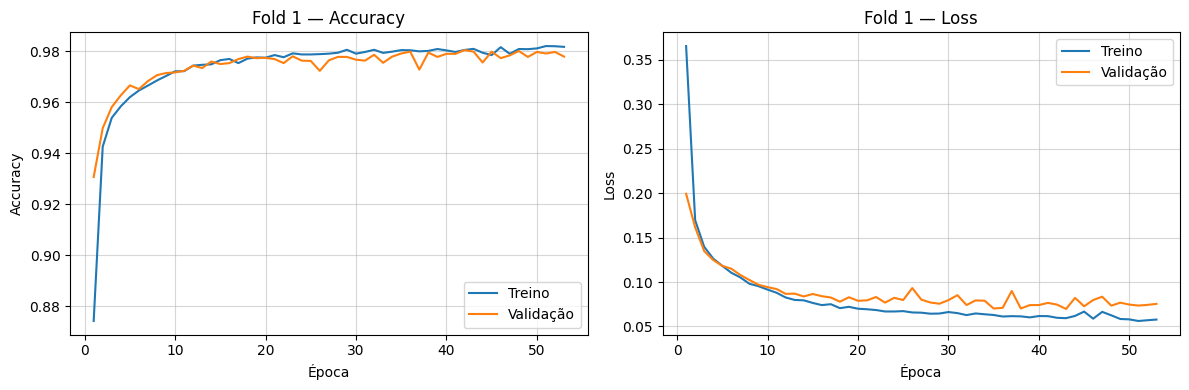

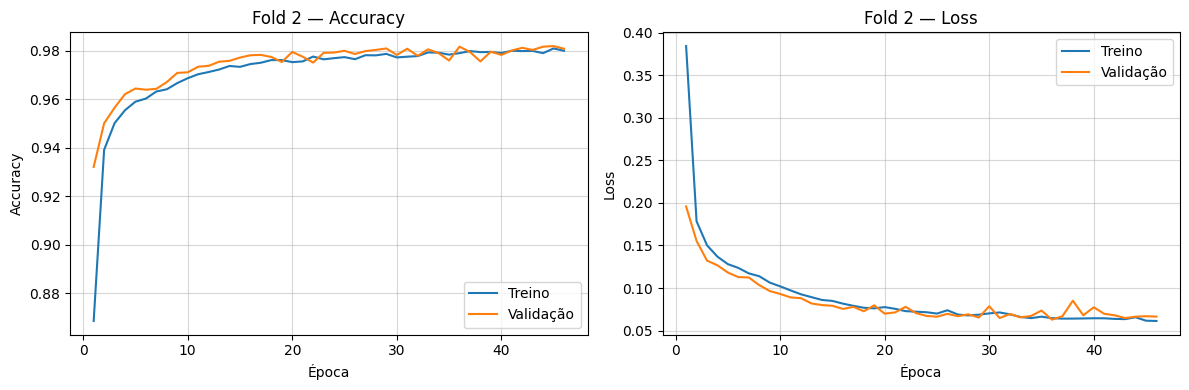

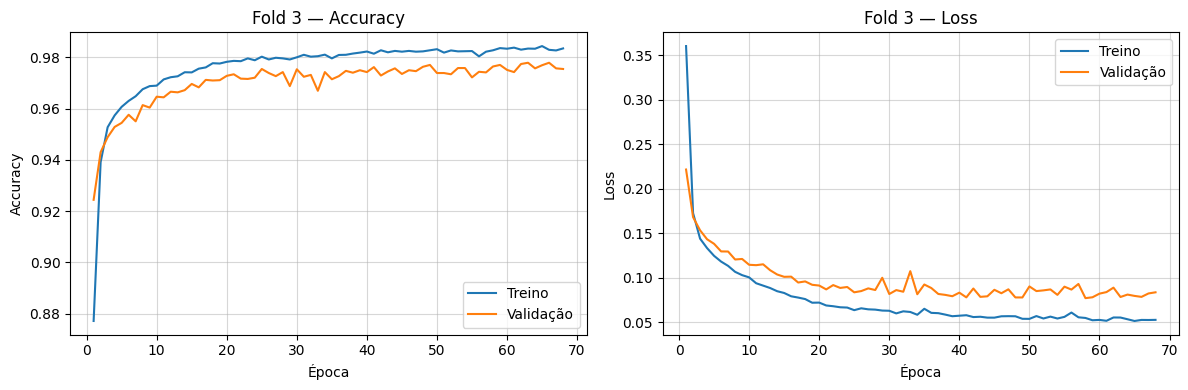

In [15]:
try:
    n_flux_features = Xf_k_s.shape[1]
    n_z_features = Xz_k_s.shape[1]
    n_ivar_features = Xivar_k_s.shape[1]
    n_classes = y_k.shape[1]

    model_builder = build_model_tuner_factory(
        n_flux_features, n_z_features, n_ivar_features, n_classes, CONFIG
    )
    
    tuner = kt.RandomSearch(
        model_builder,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='ktuner_dir',
        project_name='tune_layers_units'
)

    tuner.search([Xf_k_s, Xz_k_s, Xivar_k_s], y_k, validation_split=0.1, epochs=20, batch_size=128)

    best_hp = tuner.get_best_hyperparameters(1)[0]
    print('Best number of layers:', best_hp.get('num_layers'))

    best_model = tuner.hypermodel.build(best_hp)
    # --- 8. Validação Cruzada ---
    print(f"→ {len(Xf_k_s)} espectros para K-fold e {len(Xf_test_s)} para teste final.")
    metrics, histories = cross_validate(Xf_k_s, Xz_k_s, Xivar_k_s, y_k, CONFIG, best_hp)
    losses, accs = zip(*metrics)
    print(f"\nCV → Acurácia média: {np.mean(accs):.4f} ± {np.std(accs):.4f} | Perda média: {np.mean(losses):.4f}")

    # --- 9. Plota históricos por fold ---
    plot_histories(histories)
    
except Exception as e:
    print("Erro durante a validação cruzada:", e)
    traceback.print_exc()

In [16]:
# what the best hyperparameters are
print("Melhores hiperparâmetros encontrados:")
print(best_hp.values)

Melhores hiperparâmetros encontrados:
{'num_layers': 2, 'units_0': 64, 'dropout_0': False, 'units_1': 192, 'dropout_1': False, 'cosine_initial_lr': 0.001969521672363287, 'cosine_decay_steps': 500, 'cosine_alpha': 0.4, 'dropout_rate_0': 0.5, 'units_2': 224, 'dropout_2': True, 'units_3': 224, 'dropout_3': True, 'units_4': 32, 'dropout_4': False, 'units_5': 256, 'dropout_5': True, 'dropout_rate_1': 0.1, 'dropout_rate_4': 0.2, 'units_6': 32, 'dropout_6': False, 'dropout_rate_2': 0.2, 'dropout_rate_5': 0.2, 'dropout_rate_6': 0.4, 'units_7': 64, 'dropout_7': False, 'units_8': 32, 'dropout_8': True, 'units_9': 128, 'dropout_9': False, 'dropout_rate_7': 0.30000000000000004}



--- Treinamento Final no Pool Completo ---
Epoch 1/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8355 - loss: 0.4785 - val_accuracy: 0.9368 - val_loss: 0.1758
Epoch 2/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.1616 - val_accuracy: 0.9554 - val_loss: 0.1379
Epoch 3/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9559 - loss: 0.1383 - val_accuracy: 0.9595 - val_loss: 0.1267
Epoch 4/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9606 - loss: 0.1215 - val_accuracy: 0.9648 - val_loss: 0.1143
Epoch 5/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9648 - loss: 0.1151 - val_accuracy: 0.9700 - val_loss: 0.1091
Epoch 6/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9654 - loss: 0.1094 - val_accuracy: 0.9660 - val_loss: 0.1040
Epoch 7/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9690 - loss: 0.1017 - val_accuracy: 0.9708 - val_loss: 0.0945
Epoch 8/150
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

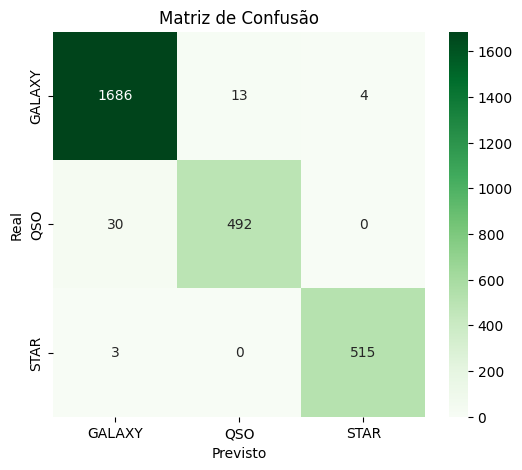

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99      1703
         QSO       0.97      0.94      0.96       522
        STAR       0.99      0.99      0.99       518

    accuracy                           0.98      2743
   macro avg       0.98      0.98      0.98      2743
weighted avg       0.98      0.98      0.98      2743



In [41]:
try:
    classes = data['le']      # ex.: array(['galaxy','quasar','star'], dtype=object)

# reconstrói o encoder
    le = LabelEncoder()
    le.classes_ = classes     # agora le.inverse_transform funciona
    # --- 10. Treinamento final e avaliação no conjunto de teste ---
    model = train_final_and_evaluate(
        Xf_k_s, Xz_k_s, Xivar_k_s, y_k,
        Xf_test_s, Xz_test_s, Xivar_test_s, y_test,
        le, CONFIG, best_hp
    )
except Exception as e:
    print("Erro durante a execução otimizada:", e)
    traceback.print_exc()

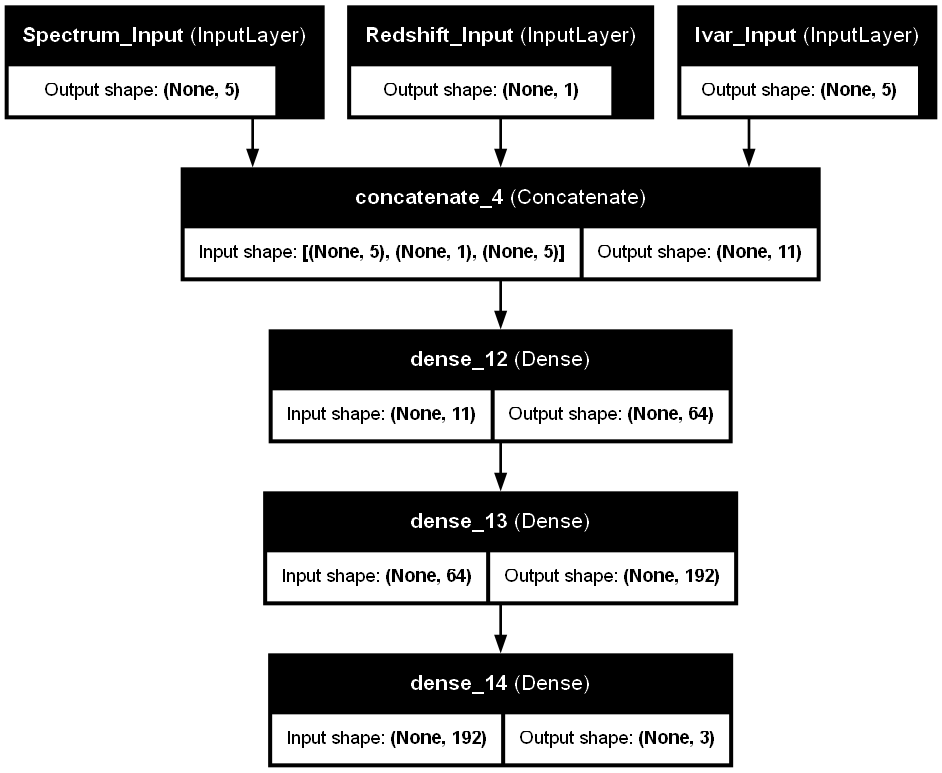

In [27]:
#png do modelo
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [42]:
model.save('saved_model/spectra_model.keras')

In [44]:
del model
tf.keras.backend.clear_session()
gc.collect()

0

In [45]:
loaded_model = tf.keras.models.load_model('saved_model/spectra_model.keras')
print("Model loaded successfully.")

# Evaluate the loaded model
# medir quanto tempo leva para avaliar o modelo
import time
start_time = time.time()
loss, acc = loaded_model.evaluate([Xf_test_s, Xz_test_s, Xivar_test_s], y_test, verbose=0)
end_time = time.time()
print(f"Tempo de avaliação: {end_time - start_time:.2f} segundos")
print(f"Acurácia do modelo carregado: {acc:.4f}")


Model loaded successfully.
Tempo de avaliação: 0.42 segundos
Acurácia do modelo carregado: 0.9818
